In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/noise2noise

Mounted at /content/drive
/content/drive/MyDrive/noise2noise


In [88]:
%reload_ext autoreload

In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
from noise2noise.training import *
from noise2noise.architectures import *
from noise2noise.helpers import *
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
training_img, _ = load_images()
mean, std = to_float_image(training_img).mean(dim=(0,2,3)), to_float_image(training_img).std(dim=(0,2,3))


to_float_and_normalize = transforms.Compose([ToFloatImage(), transforms.Normalize(mean =mean, std = std)])
to_float = transforms.Compose([ToFloatImage()])


train_loader = DataLoader(
    Noise2NoiseDataset('./dataset/train_data.pkl', 
                       transform=to_float_and_normalize, 
                       target_transform=to_float),
    batch_size = 128,
    num_workers = 2,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)

validation = DataLoader(
    Noise2NoiseDataset('./dataset/val_data.pkl', 
                       transform=to_float_and_normalize, 
                       target_transform=to_float,  
                       nb_samples=500),
    batch_size = 128,
    num_workers = 2,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)

In [84]:
import random
random.seed(0)
torch.manual_seed(0)

model = UnetWithSigmoid().to(device)
optim = Adam(model.parameters(), lr=3e-4)

metric = psnr_metric()
criterion = nn.MSELoss()


train_loss, test_loss, unetsigmoid_psnr = train(model, 
                                           train_loader, 
                                           validation, 
                                           optim, 
                                           criterion, 
                                           metric, 
                                           gradient_steps=6000, 
                                           samples_steps=1e6,
                                           lr_scheduler=None)

100%|██████████| 6000/6000 [10:05<00:00,  9.92it/s]


In [91]:
eval_model(model, validation, psnr_metric())

25.142508029937744

In [92]:
test_set = DataLoader(
    Noise2NoiseDataset('./dataset/val_data.pkl', 
                       transform=to_float_and_normalize, 
                       target_transform=to_float),
    batch_size = 128,
    num_workers = 2,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)


eval_model(model, test_set, psnr_metric())

25.13173794746399

In [93]:
torch.save(model.state_dict(), 'best_model.pth')

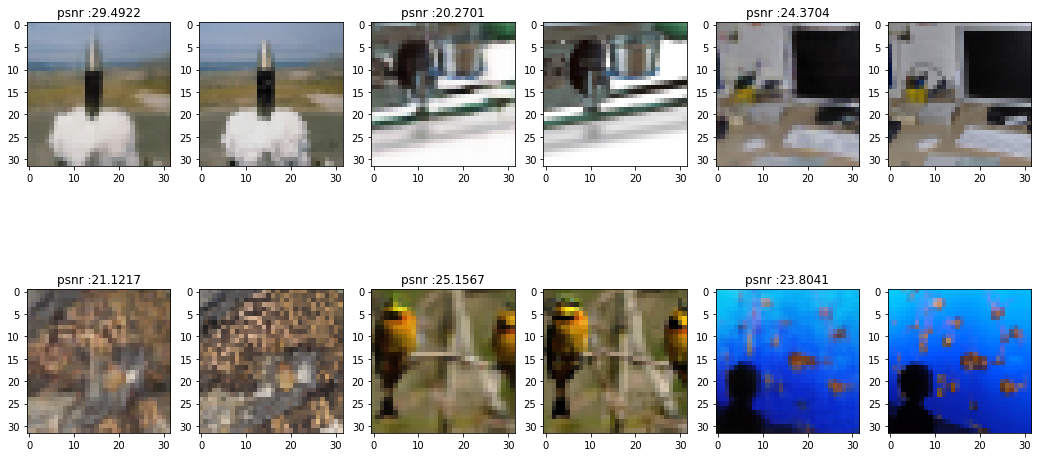

In [94]:
show_results(model, validation, nb_cols=3, nb_rows=2)

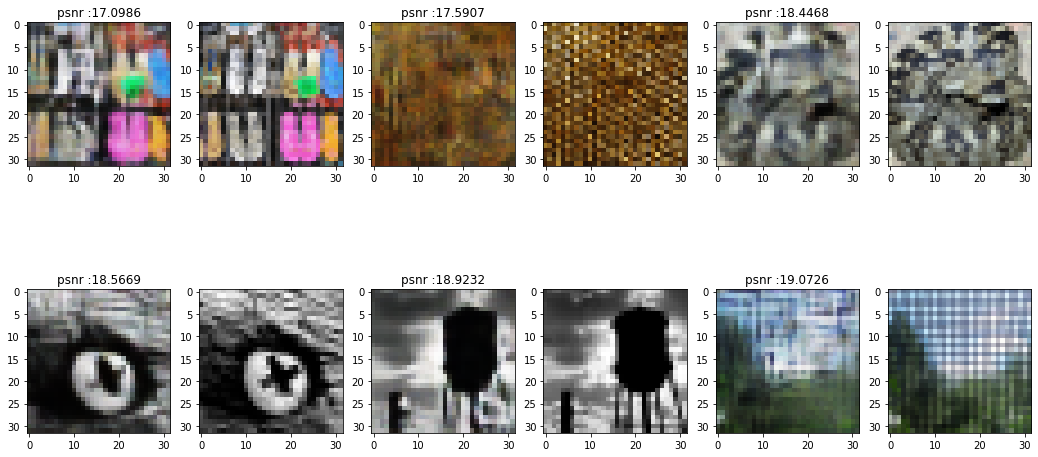

In [95]:
show_worst(model, validation, nb_cols=3, nb_rows=2)

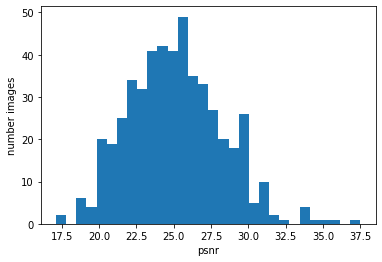

In [96]:
plot_psnr_distribution(model, validation)

In [99]:
test_load = UnetWithSigmoid().to(device)
checkpoint = torch.load('best_model.pth')
test_load.load_state_dict(checkpoint)



<All keys matched successfully>

In [100]:

test_set = DataLoader(
    Noise2NoiseDataset('./dataset/val_data.pkl', 
                       transform=to_float_and_normalize, 
                       target_transform=to_float),
    batch_size = 128,
    num_workers = 2,
    shuffle = True,
    pin_memory = torch.cuda.is_available()
)


eval_model(test_load, test_set, psnr_metric())

25.135892868041992